In [1]:
! pip install pytorch-transformers
! pip install transformers
! pip install nltk

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
cd '/content/drive/MyDrive/covid fake news'

/content/drive/MyDrive/covid fake news


# Import libraries

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

stopwords_wc = set(STOPWORDS)

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from transformers import XLMModel, BertTokenizer, BertForSequenceClassification, RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import AdamW
import nltk
from nltk.stem import 	WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import re
from torch import nn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
import seaborn as sns

# Datasets

## Social media posts

In [4]:
train_sm = pd.read_csv('data/Constraint_English_Train - Sheet1.csv', index_col = 0)
test_sm = pd.read_csv('data/Constraint_English_Test - Sheet1.csv', index_col = 0)
val_sm = pd.read_csv('data/Constraint_English_Val - Sheet1.csv', index_col = 0)
test_sm_labels = pd.read_csv('data/english_test_with_labels - Sheet1.csv', index_col = 0)
train_sm.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


In [5]:
sm_stats_ = []

for i in [train_sm, val_sm, test_sm_labels]:
  sm_stats = dict()
  sm_stats['total posts'] = len(i)
  sm_stats['fake posts'] = len(i[i['label'] == 'fake'])
  sm_stats['fake posts %'] = len(i[i['label'] == 'fake'])/len(i)*100
  sm_stats['real posts'] = len(i[i['label'] == 'real'])
  sm_stats['reak posts %'] = len(i[i['label'] == 'real'])/len(i)*100
  sm_stats_.append(sm_stats)

sm_stats_ = pd.DataFrame(sm_stats_, index = ['train', 'val', 'test'])
sm_stats_

,total posts,fake posts,fake posts %,real posts,reak posts %
train,6420,3060,47.663551,3360,52.336449
val,2140,1020,47.663551,1120,52.336449
test,2140,1020,47.663551,1120,52.336449


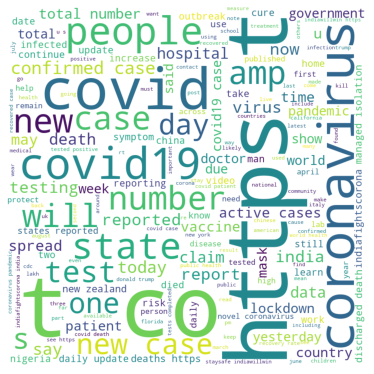

In [8]:
# train wordcloud
all_txt_train = ''

for txt in train_sm.tweet:
  txt = str(txt).lower()
  tokens = txt.split()
  all_txt_train += " ".join(tokens)+" "

wordcloud_train = WordCloud(width = 800, height = 800, 
                            background_color='white', 
                            stopwords = stopwords_wc,
                            min_font_size = 10).generate(all_txt_train)

plt.figure(figsize = (5,5), facecolor=None)
plt.imshow(wordcloud_train)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('img/wc_train_sm.png')

plt.show()

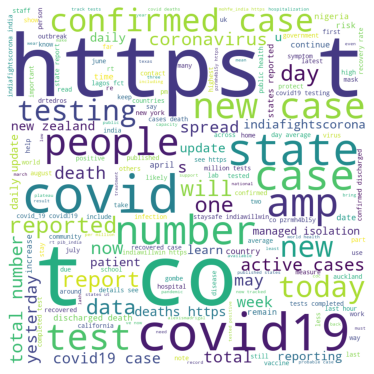

In [9]:
# train wordcloud
all_txt_train = ''

for txt in (train_sm[train_sm['label'] == 'real']).tweet:
  txt = str(txt).lower()
  tokens = txt.split()
  all_txt_train += " ".join(tokens)+" "

wordcloud_train = WordCloud(width = 800, height = 800, 
                            background_color='white', 
                            stopwords = stopwords_wc,
                            min_font_size = 10).generate(all_txt_train)

plt.figure(figsize = (5,5), facecolor=None)
plt.imshow(wordcloud_train)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('img/wc_train_sm_real.png')

plt.show()

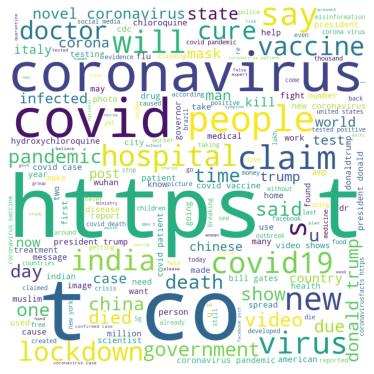

In [10]:
# train wordcloud
all_txt_train = ''

for txt in (train_sm[train_sm['label'] == 'fake']).tweet:
  txt = str(txt).lower()
  tokens = txt.split()
  all_txt_train += " ".join(tokens)+" "

wordcloud_train = WordCloud(width = 800, height = 800, 
                            background_color='white', 
                            stopwords = stopwords_wc,
                            min_font_size = 10).generate(all_txt_train)

plt.figure(figsize = (5,5), facecolor=None)
plt.imshow(wordcloud_train)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('img/wc_train_sm_fake.png')

plt.show()

## News stories

In [5]:
news = pd.read_excel('data/fake_news_dataset.xlsx', index_col=0)
# news.reset_index(inplace=True)
# del news['index']
news

,title,text,subcategory,label
0.0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,Facebook has shuttered a popular group for Mic...,false news,0.0
1.0,Other Viewpoints: COVID-19 is worse than the flu,We can now officially put to rest all comparis...,true,1.0
2.0,Bermuda's COVID-19 cases surpass 100,The Ministry of Health in Bermuda has confirme...,true,1.0
3.0,Purdue University says students face 'close to...,"Purdue University President Mitch Daniels, the...",partially false,0.0
4.0,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,Locking down much of the country may have help...,false news,0.0
...,...,...,...,...
2998.0,2019-nCoV: Health dept. on full alert,Quarantine advised for 80 persons across the S...,true,1.0
2999.0,Screening machine for corona virus launched at...,South Sudan has begun screening all travelers ...,true,1.0
3000.0,Coronavirus (2019-nCoV),Coronavirus (2019-nCoV) is a new respiratory i...,true,1.0
3001.0,Characterizing Patients Hospitalized With COVI...,Characterizing Patients Hospitalized With COVI...,false news,0.0


In [6]:
news['text'] = news['title'] + news['text']
del news['title']
# news = news.rename({'title': 'text'}, axis='columns')
del news['subcategory']
news

,text,label
0.0,FACEBOOK DELETES MICHIGAN ANTI-LOCKDOWN GROUP ...,0.0
1.0,Other Viewpoints: COVID-19 is worse than the f...,1.0
2.0,Bermuda's COVID-19 cases surpass 100The Minist...,1.0
3.0,Purdue University says students face 'close to...,0.0
4.0,THE HIGH COST OF LOCKING DOWN AMERICA: “WE’VE ...,0.0
...,...,...
2998.0,2019-nCoV: Health dept. on full alertQuarantin...,1.0
2999.0,Screening machine for corona virus launched at...,1.0
3000.0,Coronavirus (2019-nCoV)Coronavirus (2019-nCoV)...,1.0
3001.0,Characterizing Patients Hospitalized With COVI...,0.0


In [7]:
train_news, test_news = train_test_split(news, train_size=0.8, stratify=news['label'])
test_news, val_news = train_test_split(test_news, test_size = 0.5, stratify=test_news['label'])

In [14]:
news_stats_ = []

for i in [train_news, val_news, test_news]:
  news_stats = dict()
  news_stats['total posts'] = len(i)
  news_stats['fake posts'] = len(i[i['label'] == 0])
  news_stats['fake posts %'] = len(i[i['label'] == 0])/len(i)*100
  news_stats['real posts'] = len(i[i['label'] == 1])
  news_stats['real posts %'] = len(i[i['label'] == 1])/len(i)*100
  news_stats_.append(news_stats)

news_stats_ = pd.DataFrame(news_stats_, index = ['train', 'val', 'test'])
news_stats_

,total posts,fake posts,fake posts %,real posts,real posts %
train,2495,846,33.907816,1649,66.092184
val,312,106,33.974359,206,66.025641
test,312,106,33.974359,206,66.025641


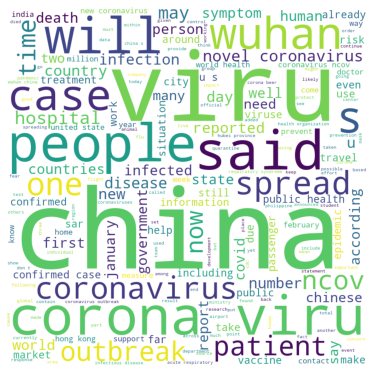

In [15]:
all_txt_train = ''

for txt in train_news.text:
  txt = str(txt).lower()
  tokens = txt.split()
  all_txt_train += " ".join(tokens)+" "

wordcloud_train = WordCloud(width = 800, height = 800, 
                            background_color='white', 
                            stopwords = stopwords_wc,
                            min_font_size = 10).generate(all_txt_train)

plt.figure(figsize = (5,5), facecolor=None)
plt.imshow(wordcloud_train)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('img/wc_train_news.png')

plt.show()

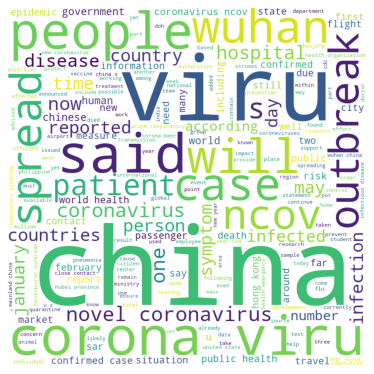

In [16]:
all_txt_train = ''

for txt in train_news[train_news['label'] == 1].text:
  txt = str(txt).lower()
  tokens = txt.split()
  all_txt_train += " ".join(tokens)+" "

wordcloud_train = WordCloud(width = 800, height = 800, 
                            background_color='white', 
                            stopwords = stopwords_wc,
                            min_font_size = 10).generate(all_txt_train)

plt.figure(figsize = (5,5), facecolor=None)
plt.imshow(wordcloud_train)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('img/wc_train_news_real.png')

plt.show()

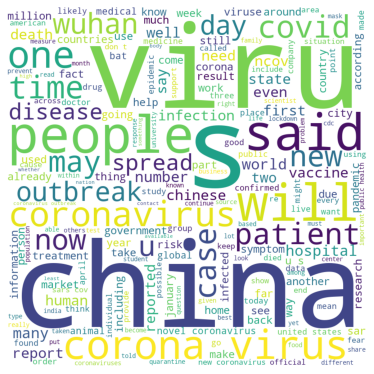

In [17]:
all_txt_train = ''

for txt in train_news[train_news['label'] == 0].text:
  txt = str(txt).lower()
  tokens = txt.split()
  all_txt_train += " ".join(tokens)+" "

wordcloud_train = WordCloud(width = 800, height = 800, 
                            background_color='white', 
                            stopwords = stopwords_wc,
                            min_font_size = 10).generate(all_txt_train)

plt.figure(figsize = (5,5), facecolor=None)
plt.imshow(wordcloud_train)
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig('img/wc_train_news_fake.png')

plt.show()

## Datasets preprocessing - Social Media

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer  = PorterStemmer()

def preprocess(row, lemmatizer, stemmer, name):
    text = str(row[name])
    tokenization = nltk.word_tokenize(text)   
    tokenization = [w for w in tokenization if not w in stop_words] 
    text = ' '.join([porter_stemmer.stem(w) for w in tokenization])
    text = ' '.join([lemmatizer.lemmatize(w) for w in tokenization])
    text = re.sub(r'\([0-9]+\)', '', text).strip()
    return text

train_sm['tweet'] = train_sm.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer, 'tweet'), 1)
val_sm['tweet'] = val_sm.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer, 'tweet'), 1)
test_sm['tweet'] = test_sm.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer, 'tweet'), 1)

In [10]:
def map_label(row):
  return 1 if row['label'] == 'real' else 0

train_sm['label_encoded'] = train_sm.apply(lambda x: map_label(x), 1)
val_sm['label_encoded'] = val_sm.apply(lambda x: map_label(x), 1)
test_sm_labels['label_encoded'] = test_sm_labels.apply(lambda x: map_label(x), 1)

train_sentences_sm = train_sm.tweet.values
val_sentences_sm = val_sm.tweet.values
test_sentences_sm = test_sm.tweet.values

train_labels_sm = train_sm.label_encoded.values
val_labels_sm = val_sm.label_encoded.values
test_labels_sm = test_sm_labels.label_encoded.values

## Datasets preprocessing - news

In [11]:
train_news['text'] = train_news.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer, 'text'), 1)
val_news['text'] = val_news.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer, 'text'), 1)
test_news['text'] = test_news.apply(lambda x: preprocess(x, wordnet_lemmatizer, porter_stemmer, 'text'), 1)

train_sentences_news = train_news.text.values
val_sentences_news = val_news.text.values
test_sentences_news = test_news.text.values

train_labels_news = np.int16(train_news.label.values)
val_labels_news = np.int16(val_news.label.values)
test_labels_news = np.int16(test_news.label.values)

## Encoding functions

In [12]:
def encode_text(sentence,tokenizer,maxlen,padding_type='max_length',attention_mask_flag=True):
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=maxlen, truncation=True, padding=padding_type, return_attention_mask=attention_mask_flag)
    return encoded_dict['input_ids'],encoded_dict['attention_mask']

def get_tokenized_text (sentenceList, tokenizer):
    token_ids_list,attention_mask_list = [],[]
    for sentence in sentenceList:
        token_ids,attention_mask = encode_text(sentence,tokenizer,128)
        token_ids_list.append(token_ids)
        attention_mask_list.append(attention_mask)
    return token_ids_list,attention_mask_list

In [13]:
def accuracy(pred, label):
    pred = np.argmax(pred, axis=1).flatten()
    labels = label.flatten()
    return np.sum(pred == labels) / len(labels)

# Social media posts models

## BERT

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_sm_ids, train_attention = torch.tensor(get_tokenized_text(train_sentences_sm, tokenizer))
val_sm_ids, val_attention = torch.tensor(get_tokenized_text(val_sentences_sm, tokenizer))
test_sm_ids, test_attention = torch.tensor(get_tokenized_text(test_sentences_sm, tokenizer))
train_label_sm = torch.tensor(train_labels_sm)
val_label_sm = torch.tensor(val_labels_sm)
test_label_sm = torch.tensor(test_labels_sm)

In [36]:
train_data_sm = TensorDataset(train_sm_ids, train_attention, train_label_sm)
train_sampler_sm = RandomSampler(train_data_sm)
train_dataloader = DataLoader(train_data_sm, sampler = train_sampler_sm, batch_size = 32)

val_data_sm = TensorDataset(val_sm_ids, val_attention, val_label_sm)
validation_sampler_sm = SequentialSampler(val_data_sm)
validation_dataloader = DataLoader(val_data_sm, sampler=validation_sampler_sm, batch_size=32)

test_data_sm = TensorDataset(test_sm_ids, test_attention, test_label_sm)
test_sampler_sm = SequentialSampler(test_data_sm)
test_dataloader = DataLoader(test_data_sm, sampler=test_sampler_sm, batch_size=32)

In [37]:
# news data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_news_ids, train_attention_news = torch.tensor(get_tokenized_text(train_sentences_news, tokenizer))
val_news_ids, val_attention_news = torch.tensor(get_tokenized_text(val_sentences_news, tokenizer))
test_news_ids, test_attention_news = torch.tensor(get_tokenized_text(test_sentences_news, tokenizer))
train_label_news = torch.tensor(train_labels_news)
val_label_news = torch.tensor(val_labels_news)
test_label_news = torch.tensor(test_labels_news)

train_data_news = TensorDataset(train_news_ids, train_attention_news, train_label_news)
train_sampler_news = RandomSampler(train_data_news)
train_dataloader_news = DataLoader(train_data_news, sampler = train_sampler_news, batch_size = 32)

val_data_news = TensorDataset(val_news_ids, val_attention_news, val_label_news)
validation_sampler_news = SequentialSampler(val_data_news)
validation_dataloader_news = DataLoader(val_data_news, sampler=validation_sampler_news, batch_size=32)

test_data_news = TensorDataset(test_news_ids, test_attention_news, test_label_news)
test_sampler_news = SequentialSampler(test_data_news)
test_dataloader_news = DataLoader(test_data_news, sampler=test_sampler_news, batch_size=32)

In [39]:
def eval(dataloader, name, model, flag):
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  pred = []
  true = []

  for batch in dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
          logits = output[0]

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        pred.append(np.argmax(logits, axis=1).flatten())
        true.append(label_ids.flatten())

  pred = [item for sublist in pred for item in sublist]
  true = [item for sublist in true for item in sublist]
  print(f'{name} classification report')
  print(f'Accuary {accuracy_score(true, pred)}')
  print(f'Precision {precision_score(true, pred)}')
  print(f'Recall {recall_score(true, pred)}')
  print(f'F1 {f1_score(true, pred)}\n\n')

  if flag: 
    cf_matrix = confusion_matrix(true, pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.tight_layout()
    plt.savefig(f'img/{name}.png')
    plt.show()
    # [item for sublist in labels for item in sublist]

### Bert with social media posts

In [ ]:
bert_sm = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

param_optimizer = list(bert_sm.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
epochs = 15
train_loss_set = []

for i in range(epochs):
  print(f'========== Epoch {i} ==========')
  bert_sm.train().to(device)
  tr_loss, nb_tr_samples, nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = bert_sm(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_samples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  bert_sm.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        output = bert_sm(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

========== Epoch 0 ==========
Train loss: 0.22130987617136233
Validation Accuracy: 0.9612206823027718
========== Epoch 1 ==========
Train loss: 0.07268461016057735
Validation Accuracy: 0.972481343283582
========== Epoch 2 ==========
Train loss: 0.03573234860127356
Validation Accuracy: 0.9728811300639658
========== Epoch 3 ==========
Train loss: 0.02247963380589803
Validation Accuracy: 0.976679104477612
========== Epoch 4 ==========
Train loss: 0.008746626361769008
Validation Accuracy: 0.9701492537313433
========== Epoch 5 ==========
Train loss: 0.010302904211980898
Validation Accuracy: 0.9762126865671642
========== Epoch 6 ==========
Train loss: 0.007460445779565703
Validation Accuracy: 0.960820895522388
========== Epoch 7 ==========
Train loss: 0.010375591352598195
Validation Accuracy: 0.9775453091684434
========== Epoch 8 ==========
Train loss: 0.003779360268088938
Validation Accuracy: 0.9794776119402985
========== Epoch 9 ==========
Train loss: 0.005405007562118198
Validation Accura

In [ ]:
torch.save(bert_sm.state_dict(), 'models/BERT_sm.ckpt')

In [40]:
bert_sm = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
bert_sm.load_state_dict(torch.load('models/BERT_sm.ckpt'))
bert_sm.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Social Media accuracy: 
Train classification report
Accuary 1.0
Precision 1.0
Recall 1.0
F1 1.0


Val classification report
Accuary 0.9794392523364486
Precision 0.9744268077601411
Recall 0.9866071428571429
F1 0.9804791481810116


Test_BertSM classification report
Accuary 0.974766355140187
Precision 0.968365553602812
Recall 0.9839285714285714
F1 0.9760850310008857




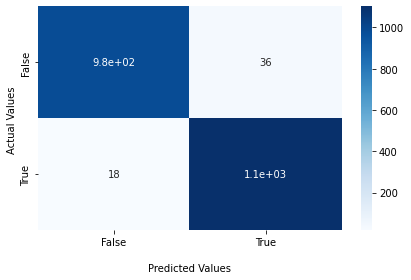

In [41]:
# predictions for social media
print('Social Media accuracy: ')
eval(train_dataloader, 'Train', bert_sm, False)
eval(validation_dataloader, 'Val', bert_sm, False)
eval(test_dataloader, 'Test_BertSM', bert_sm, True)

In [42]:
print('News accuracy: ')
eval(train_dataloader_news, 'Train', bert_sm, False)
eval(validation_dataloader_news, 'Val', bert_sm, False)
eval(test_dataloader_news, 'Test', bert_sm, False)

News accuracy: 
Train classification report
Accuary 0.3406813627254509
Precision 0.7
Recall 0.004244996967859308
F1 0.008438818565400843


Val classification report
Accuary 0.33974358974358976
Precision 0.5
Recall 0.0048543689320388345
F1 0.009615384615384614


Test classification report
Accuary 0.33974358974358976
Precision 0.0
Recall 0.0
F1 0.0




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bert with news stories 

In [28]:
bert_news = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

param_optimizer = list(bert_news.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
epochs = 15
train_loss_set = []
criterion = nn.CrossEntropyLoss()

for i in range(epochs):
  print(f'========== Epoch {i} ==========')
  bert_news.train().to(device)
  tr_loss, nb_tr_samples, nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader_news):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = bert_news(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    loss = outputs[0]
    loss = criterion(loss, b_labels.long())
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_samples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  bert_news.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader_news:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        output = bert_news(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

========== Epoch 0 ==========
Train loss: 0.5530950106107272
Validation Accuracy: 0.8197916666666666
========== Epoch 1 ==========
Train loss: 0.4078944084736017
Validation Accuracy: 0.796875
========== Epoch 2 ==========
Train loss: 0.3201884822203563
Validation Accuracy: 0.8
========== Epoch 3 ==========
Train loss: 0.20977756701027736
Validation Accuracy: 0.7875
========== Epoch 4 ==========
Train loss: 0.13770113345713186
Validation Accuracy: 0.8052083333333334
========== Epoch 5 ==========
Train loss: 0.09954702356257118
Validation Accuracy: 0.7822916666666667
========== Epoch 6 ==========
Train loss: 0.08286698115989566
Validation Accuracy: 0.7979166666666667
========== Epoch 7 ==========
Train loss: 0.06709913871227166
Validation Accuracy: 0.7979166666666667
========== Epoch 8 ==========
Train loss: 0.05199571278017874
Validation Accuracy: 0.8010416666666667
========== Epoch 9 ==========
Train loss: 0.04287010155773411
Validation Accuracy: 0.7979166666666667
========== Epoch 10 

In [29]:
torch.save(bert_news.state_dict(), 'models/BERT_news.ckpt')

In [43]:
bert_news = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
bert_news.load_state_dict(torch.load('models/BERT_news.ckpt'))
bert_news.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

News accuracy: 
Train classification report
Accuary 0.9527054108216433
Precision 0.9603126879134095
Recall 0.968465736810188
F1 0.9643719806763286


Val classification report
Accuary 0.9647435897435898
Precision 0.9802955665024631
Recall 0.9660194174757282
F1 0.9731051344743277


Test_BertNEWS classification report
Accuary 0.9391025641025641
Precision 0.9651741293532339
Recall 0.941747572815534
F1 0.9533169533169533




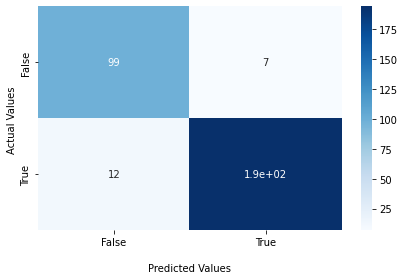

In [44]:
print('News accuracy: ')
eval(train_dataloader_news, 'Train', bert_news, False)
eval(validation_dataloader_news, 'Val', bert_news, False)
eval(test_dataloader_news, 'Test_BertNEWS', bert_news, True)

In [45]:
print('Social Media accuracy: ')
eval(train_dataloader, 'Train', bert_news, False)
eval(validation_dataloader, 'Val', bert_news, False)
eval(test_dataloader, 'Test', bert_news, False)

Social Media accuracy: 
Train classification report
Accuary 0.467601246105919
Precision 0.42676767676767674
Recall 0.05029761904761905
F1 0.08998935037273696


Val classification report
Accuary 0.47289719626168225
Precision 0.4722222222222222
Recall 0.060714285714285714
F1 0.10759493670886075


Test classification report
Accuary 0.47289719626168225
Precision 0.4701492537313433
Recall 0.05625
F1 0.10047846889952153




## RoBERTa

In [56]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification

In [57]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', do_lower_case=True)

train_sm_ids, train_attention = torch.tensor(get_tokenized_text(train_sentences_sm, tokenizer))
val_sm_ids, val_attention = torch.tensor(get_tokenized_text(val_sentences_sm, tokenizer))
test_sm_ids, test_attention = torch.tensor(get_tokenized_text(test_sentences_sm, tokenizer))
train_label_sm = torch.tensor(train_labels_sm)
val_label_sm = torch.tensor(val_labels_sm)
test_label_sm = torch.tensor(test_labels_sm)

In [58]:
train_data_sm = TensorDataset(train_sm_ids, train_attention, train_label_sm)
train_sampler_sm = RandomSampler(train_data_sm)
train_dataloader = DataLoader(train_data_sm, sampler = train_sampler_sm, batch_size = 32)

val_data_sm = TensorDataset(val_sm_ids, val_attention, val_label_sm)
validation_sampler_sm = SequentialSampler(val_data_sm)
validation_dataloader = DataLoader(val_data_sm, sampler=validation_sampler_sm, batch_size=32)

test_data_sm = TensorDataset(test_sm_ids, test_attention, test_label_sm)
test_sampler_sm = SequentialSampler(test_data_sm)
test_dataloader = DataLoader(test_data_sm, sampler=test_sampler_sm, batch_size=32)

In [59]:
# news data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_news_ids, train_attention_news = torch.tensor(get_tokenized_text(train_sentences_news, tokenizer))
val_news_ids, val_attention_news = torch.tensor(get_tokenized_text(val_sentences_news, tokenizer))
test_news_ids, test_attention_news = torch.tensor(get_tokenized_text(test_sentences_news, tokenizer))
train_label_news = torch.tensor(train_labels_news)
val_label_news = torch.tensor(val_labels_news)
test_label_news = torch.tensor(test_labels_news)

train_data_news = TensorDataset(train_news_ids, train_attention_news, train_label_news)
train_sampler_news = RandomSampler(train_data_news)
train_dataloader_news = DataLoader(train_data_news, sampler = train_sampler_news, batch_size = 32)

val_data_news = TensorDataset(val_news_ids, val_attention_news, val_label_news)
validation_sampler_news = SequentialSampler(val_data_news)
validation_dataloader_news = DataLoader(val_data_news, sampler=validation_sampler_news, batch_size=32)

test_data_news = TensorDataset(test_news_ids, test_attention_news, test_label_news)
test_sampler_news = SequentialSampler(test_data_news)
test_dataloader_news = DataLoader(test_data_news, sampler=test_sampler_news, batch_size=32)

### RoBERTa with social media posts

In [ ]:
roberta_sm = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).cuda()

param_optimizer = list(roberta_sm.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
epochs = 15
train_loss_set = []

for i in range(epochs):
  print(f'========== Epoch {i} ==========')
  roberta_sm.train().to(device)
  tr_loss, nb_tr_samples, nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = roberta_sm(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_samples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        output = roberta_sm(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

========== Epoch 0 ==========
Train loss: 0.2169090499869775
Validation Accuracy: 0.9561567164179104
========== Epoch 1 ==========
Train loss: 0.07475400908817699
Validation Accuracy: 0.9630863539445628
========== Epoch 2 ==========
Train loss: 0.04906627637697893
Validation Accuracy: 0.9734141791044776
========== Epoch 3 ==========
Train loss: 0.02707586286992613
Validation Accuracy: 0.9691497867803837
========== Epoch 4 ==========
Train loss: 0.025522609750117033
Validation Accuracy: 0.9644856076759061
========== Epoch 5 ==========
Train loss: 0.015457691158085774
Validation Accuracy: 0.9663512793176972
========== Epoch 6 ==========
Train loss: 0.01765668209109615
Validation Accuracy: 0.976679104477612
========== Epoch 7 ==========
Train loss: 0.00604689630530792
Validation Accuracy: 0.9738805970149254
========== Epoch 8 ==========
Train loss: 0.0072943311355430605
Validation Accuracy: 0.9589552238805971
========== Epoch 9 ==========
Train loss: 0.008910501252247927
Validation Accura

In [ ]:
torch.save(roberta_sm.state_dict(), 'models/roBERTa_sm.ckpt')

In [63]:
roberta_sm = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)
roberta_sm.load_state_dict(torch.load('models/roBERTa_sm.ckpt'))
roberta_sm.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

Social Media accuracy: 
Train classification report
Accuary 0.9993769470404984
Precision 0.9988109393579072
Recall 1.0
F1 0.9994051160023795


Val classification report
Accuary 0.9742990654205608
Precision 0.958656330749354
Recall 0.99375
F1 0.9758877685225779


Test_roBERTaSM classification report
Accuary 0.97803738317757
Precision 0.967741935483871
Recall 0.9910714285714286
F1 0.9792677547419497




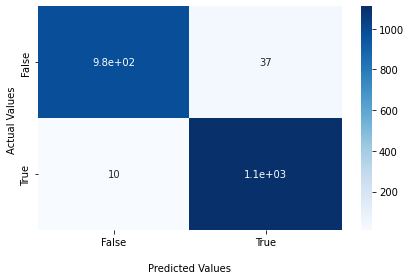

In [64]:
# predictions for social media
print('Social Media accuracy: ')
eval(train_dataloader, 'Train', roberta_sm, False)
eval(validation_dataloader, 'Val', roberta_sm, False)
eval(test_dataloader, 'Test_roBERTaSM', roberta_sm, True)

In [65]:
print('News accuracy: ')
eval(train_dataloader_news, 'Train', roberta_sm, False)
eval(validation_dataloader_news, 'Val', roberta_sm, False)
eval(test_dataloader_news, 'Test', roberta_sm, False)

News accuracy: 
Train classification report
Accuary 0.5490981963927856
Precision 0.687948350071736
Recall 0.5815645845967253
F1 0.6302990469930989


Val classification report
Accuary 0.5544871794871795
Precision 0.6892655367231638
Recall 0.5922330097087378
F1 0.6370757180156658


Test classification report
Accuary 0.532051282051282
Precision 0.6630434782608695
Recall 0.5922330097087378
F1 0.6256410256410256




### RoBERTa with news stories 

In [ ]:
roberta_news = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).cuda()

param_optimizer = list(roberta_news.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
epochs = 15
train_loss_set = []
criterion = nn.CrossEntropyLoss()

for i in range(epochs):
  print(f'========== Epoch {i} ==========')
  roberta_news.train().to(device)
  tr_loss, nb_tr_samples, nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader_news):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = roberta_news(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    loss = outputs[0]
    loss = criterion(loss, b_labels.long())
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_samples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  roberta_news.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader_news:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        output = roberta_news(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

========== Epoch 0 ==========
Train loss: 0.6480073145566843
Validation Accuracy: 0.6604166666666667
========== Epoch 1 ==========
Train loss: 0.5775900486952219
Validation Accuracy: 0.7166666666666667
========== Epoch 2 ==========
Train loss: 0.5051167664619592
Validation Accuracy: 0.834375
========== Epoch 3 ==========
Train loss: 0.43843716172835767
Validation Accuracy: 0.825
========== Epoch 4 ==========
Train loss: 0.38401977202067006
Validation Accuracy: 0.7989583333333333
========== Epoch 5 ==========
Train loss: 0.351406376522321
Validation Accuracy: 0.8458333333333334
========== Epoch 6 ==========
Train loss: 0.3237426854574528
Validation Accuracy: 0.7583333333333333
========== Epoch 7 ==========
Train loss: 0.2588161638436409
Validation Accuracy: 0.828125
========== Epoch 8 ==========
Train loss: 0.18694827512193185
Validation Accuracy: 0.7822916666666667
========== Epoch 9 ==========
Train loss: 0.15330014516336796
Validation Accuracy: 0.8083333333333333
========== Epoch 10 

In [ ]:
torch.save(roberta_news.state_dict(), 'models/roBERTa_news.ckpt')

In [60]:
roberta_news = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2).to(device)
roberta_news.load_state_dict(torch.load('models/roBERTa_news.ckpt'))
roberta_news.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

News accuracy: 
Train classification report
Accuary 0.9434869739478958
Precision 0.9671623296158612
Recall 0.9466343238326258
F1 0.9567882316886303


Val classification report
Accuary 0.9358974358974359
Precision 0.979381443298969
Recall 0.9223300970873787
F1 0.95


Test_roBERTaNEWS classification report
Accuary 0.9391025641025641
Precision 0.9698492462311558
Recall 0.9368932038834952
F1 0.9530864197530864




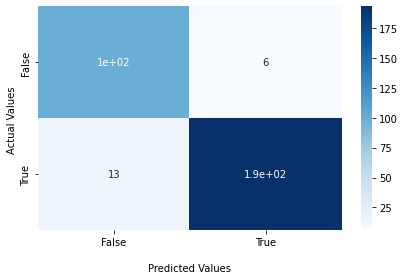

In [61]:
print('News accuracy: ')
eval(train_dataloader_news, 'Train', roberta_news, False)
eval(validation_dataloader_news, 'Val', roberta_news, False)
eval(test_dataloader_news, 'Test_roBERTaNEWS', roberta_news, True)

In [62]:
print('Social Media accuracy: ')
eval(train_dataloader, 'Train', roberta_news, False)
eval(validation_dataloader, 'Val', roberta_news, False)
eval(test_dataloader, 'Test', roberta_news, False)

Social Media accuracy: 
Train classification report
Accuary 0.4700934579439252
Precision 0.16129032258064516
Recall 0.002976190476190476
F1 0.0058445353594389245


Val classification report
Accuary 0.4705607476635514
Precision 0.15789473684210525
Recall 0.0026785714285714286
F1 0.005267778753292362


Test classification report
Accuary 0.4691588785046729
Precision 0.21428571428571427
Recall 0.005357142857142857
F1 0.010452961672473867




## DeBERTa

In [46]:
from transformers import DebertaTokenizer, DebertaModel, DebertaForSequenceClassification

In [47]:
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

train_sm_ids, train_attention = torch.tensor(get_tokenized_text(train_sentences_sm, tokenizer))
val_sm_ids, val_attention = torch.tensor(get_tokenized_text(val_sentences_sm, tokenizer))
test_sm_ids, test_attention = torch.tensor(get_tokenized_text(test_sentences_sm, tokenizer))
train_label_sm = torch.tensor(train_labels_sm)
val_label_sm = torch.tensor(val_labels_sm)
test_label_sm = torch.tensor(test_labels_sm)

In [48]:
train_data_sm = TensorDataset(train_sm_ids, train_attention, train_label_sm)
train_sampler_sm = RandomSampler(train_data_sm)
train_dataloader = DataLoader(train_data_sm, sampler = train_sampler_sm, batch_size = 32)

val_data_sm = TensorDataset(val_sm_ids, val_attention, val_label_sm)
validation_sampler_sm = SequentialSampler(val_data_sm)
validation_dataloader = DataLoader(val_data_sm, sampler=validation_sampler_sm, batch_size=32)

test_data_sm = TensorDataset(test_sm_ids, test_attention, test_label_sm)
test_sampler_sm = SequentialSampler(test_data_sm)
test_dataloader = DataLoader(test_data_sm, sampler=test_sampler_sm, batch_size=32)

In [49]:
# news data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

train_news_ids, train_attention_news = torch.tensor(get_tokenized_text(train_sentences_news, tokenizer))
val_news_ids, val_attention_news = torch.tensor(get_tokenized_text(val_sentences_news, tokenizer))
test_news_ids, test_attention_news = torch.tensor(get_tokenized_text(test_sentences_news, tokenizer))
train_label_news = torch.tensor(train_labels_news)
val_label_news = torch.tensor(val_labels_news)
test_label_news = torch.tensor(test_labels_news)

train_data_news = TensorDataset(train_news_ids, train_attention_news, train_label_news)
train_sampler_news = RandomSampler(train_data_news)
train_dataloader_news = DataLoader(train_data_news, sampler = train_sampler_news, batch_size = 32)

val_data_news = TensorDataset(val_news_ids, val_attention_news, val_label_news)
validation_sampler_news = SequentialSampler(val_data_news)
validation_dataloader_news = DataLoader(val_data_news, sampler=validation_sampler_news, batch_size=32)

test_data_news = TensorDataset(test_news_ids, test_attention_news, test_label_news)
test_sampler_news = SequentialSampler(test_data_news)
test_dataloader_news = DataLoader(test_data_news, sampler=test_sampler_news, batch_size=32)

### DeBERTa with social media posts

In [ ]:
debert_sm = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2).cuda()

param_optimizer = list(debert_sm.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
epochs = 15
train_loss_set = []

for i in range(epochs):
  print(f'========== Epoch {i} ==========')
  debert_sm.train().to(device)
  tr_loss, nb_tr_samples, nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = debert_sm(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_samples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  debert_sm.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        output = debert_sm(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'classifi

========== Epoch 0 ==========
Train loss: 0.3420999892778806
Validation Accuracy: 0.9480943496801706
========== Epoch 1 ==========
Train loss: 0.08529729789136839
Validation Accuracy: 0.9677505330490405
========== Epoch 2 ==========
Train loss: 0.04459387734092179
Validation Accuracy: 0.9794109808102345
========== Epoch 3 ==========
Train loss: 0.023468242753882065
Validation Accuracy: 0.9770788912579956
========== Epoch 4 ==========
Train loss: 0.017371135633653122
Validation Accuracy: 0.9789445628997867
========== Epoch 5 ==========
Train loss: 0.01782998365430574
Validation Accuracy: 0.9784781449893389
========== Epoch 6 ==========
Train loss: 0.005772993376592072
Validation Accuracy: 0.9682169509594882
========== Epoch 7 ==========
Train loss: 0.00894955155205541
Validation Accuracy: 0.9770788912579956
========== Epoch 8 ==========
Train loss: 0.0012266718483772083
Validation Accuracy: 0.9775453091684434
========== Epoch 9 ==========
Train loss: 0.0071880114525779545
Validation Acc

In [ ]:
torch.save(debert_sm.state_dict(), 'models/deBERT_sm.ckpt')

In [50]:
debert_sm = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2).to(device)
debert_sm.load_state_dict(torch.load('models/deBERT_sm.ckpt'))
debert_sm.eval()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

Social Media accuracy: 


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Train classification report
Accuary 1.0
Precision 1.0
Recall 1.0
F1 1.0




/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Val classification report
Accuary 0.9799065420560747
Precision 0.9727831431079894
Recall 0.9892857142857143
F1 0.9809650287737937




/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Test_deBERTaSM classification report
Accuary 0.9752336448598131
Precision 0.9683933274802459
Recall 0.9848214285714286
F1 0.9765382912793271




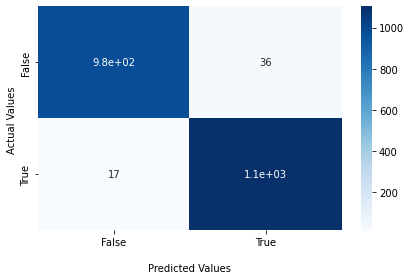

In [51]:
# predictions for social media
print('Social Media accuracy: ')
eval(train_dataloader, 'Train', debert_sm, False)
eval(validation_dataloader, 'Val', debert_sm, False)
eval(test_dataloader, 'Test_deBERTaSM', debert_sm, True)

In [52]:
print('News accuracy: ')
eval(train_dataloader_news, 'Train', debert_sm, False)
eval(validation_dataloader_news, 'Val', debert_sm, False)
eval(test_dataloader_news, 'Test', debert_sm, False)

News accuracy: 


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Train classification report
Accuary 0.33947895791583166
Precision 0.5054945054945055
Recall 0.027895694360218316
F1 0.052873563218390804




/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Val classification report
Accuary 0.3333333333333333
Precision 0.4375
Recall 0.03398058252427184
F1 0.06306306306306307




/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Test classification report
Accuary 0.33974358974358976
Precision 0.5
Recall 0.02912621359223301
F1 0.05504587155963303




### DeBERTa with news stories 

In [ ]:
debert_news = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2).cuda()

param_optimizer = list(debert_news.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
epochs = 15
train_loss_set = []
criterion = nn.CrossEntropyLoss()

for i in range(epochs):
  print(f'========== Epoch {i} ==========')
  debert_news.train().to(device)
  tr_loss, nb_tr_samples, nb_tr_steps = 0, 0, 0

  for step, batch in enumerate(train_dataloader_news):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    outputs = debert_news(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    loss = outputs[0]
    loss = criterion(loss, b_labels.long())
    train_loss_set.append(loss.item())
    loss.backward()
    optimizer.step()

    tr_loss += loss.item()
    nb_tr_samples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

  debert_news.eval()

  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  for batch in validation_dataloader_news:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        output = debert_news(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = output[0]

      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy = accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.weight', 'classifi

========== Epoch 0 ==========
Train loss: 0.6456618729310158
Validation Accuracy: 0.6895833333333333
========== Epoch 1 ==========
Train loss: 0.5502359446806785
Validation Accuracy: 0.7708333333333333
========== Epoch 2 ==========
Train loss: 0.45628412946676594
Validation Accuracy: 0.7677083333333333
========== Epoch 3 ==========
Train loss: 0.41413318671477145
Validation Accuracy: 0.778125
========== Epoch 4 ==========
Train loss: 0.3273544352597151
Validation Accuracy: 0.7677083333333333
========== Epoch 5 ==========
Train loss: 0.2943863703463322
Validation Accuracy: 0.7916666666666667
========== Epoch 6 ==========
Train loss: 0.24993239992704147
Validation Accuracy: 0.7552083333333333
========== Epoch 7 ==========
Train loss: 0.19730558953224084
Validation Accuracy: 0.8020833333333334
========== Epoch 8 ==========
Train loss: 0.16007905711348241
Validation Accuracy: 0.7697916666666667
========== Epoch 9 ==========
Train loss: 0.13363051767914724
Validation Accuracy: 0.76979166666

In [ ]:
torch.save(debert_news.state_dict(), 'models/deBERT_news.ckpt')

In [53]:
debert_news = DebertaForSequenceClassification.from_pretrained("microsoft/deberta-base", num_labels=2).to(device)
debert_news.load_state_dict(torch.load('models/deBERT_news.ckpt'))
debert_news.eval()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermed

News accuracy: 


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Train classification report
Accuary 0.9438877755511023
Precision 0.9499105545617174
Recall 0.9660400242571255
F1 0.957907396271798




/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Val classification report
Accuary 0.9711538461538461
Precision 0.9758454106280193
Recall 0.9805825242718447
F1 0.9782082324455206




/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Test_deBERTaNEWS classification report
Accuary 0.9423076923076923
Precision 0.9476190476190476
Recall 0.9660194174757282
F1 0.9567307692307693




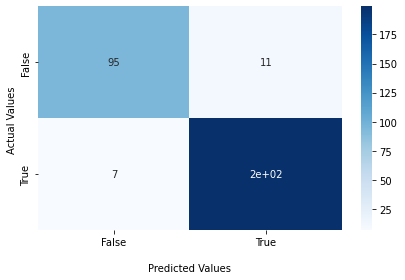

In [54]:
print('News accuracy: ')
eval(train_dataloader_news, 'Train', debert_news, False)
eval(validation_dataloader_news, 'Val', debert_news, False)
eval(test_dataloader_news, 'Test_deBERTaNEWS', debert_news, True)

In [55]:
print('Social Media accuracy: ')
eval(train_dataloader, 'Train', debert_news, False)
eval(validation_dataloader, 'Val', debert_news, False)
eval(test_dataloader, 'Test', debert_news, False)

Social Media accuracy: 


/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_layer.transpose(-1, -2), dtype=key_layer.dtype))


Train classification report
Accuary 0.4766355140186916
Precision 0.0
Recall 0.0
F1 0.0




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_

Val classification report
Accuary 0.4766355140186916
Precision 0.0
Recall 0.0
F1 0.0




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tensor(scale, dtype=query_layer.dtype)
/usr/local/lib/python3.7/dist-packages/transformers/models/deberta/modeling_deberta.py:745: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p2c_att = torch.matmul(key_layer, torch.tensor(pos_query_

Test classification report
Accuary 0.4766355140186916
Precision 0.0
Recall 0.0
F1 0.0




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
